#### Test the performance of the n-shot leanrning using the leave-one-out test set of each fold
**Note**: each k and each fold is an independent training

In each k and each fold we do the following to test the performance of the siamese network:
1. Load the support set and the test set for each k and each fold 
2. Select a sample from the test set, and predict the similarity score between it with each sample in the support set
3. Repeat 2 for all the samples from the test set

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import keras
import tensorflow as tf
import os
from keras import backend as k
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, Callback

from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import softmax
from scipy.stats import entropy
from scipy.ndimage import rotate
from skimage.transform import resize

rng = np.random.default_rng(seed=42)

2024-09-04 22:42:23.390290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 22:42:23.402128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 22:42:23.405670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 22:42:23.415690: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 22:42:24.056153: W tensorflow/compiler/tf2

In [2]:
# Load the support data and test data
# Here we take 3-shot 1 fold for example
# Change this to a loop to exhaust all the data partitioning 
k = 3
i = 1

support_smaples_path = f'/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/n_fold_x_validation/{k}_shot_{i}_fold_supp_samples.zarr'
test_samples_path = f'/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/n_fold_x_validation/{k}_shot_{i}_fold_test_samples.zarr'

support_samples = xr.open_zarr(support_smaples_path)
test_samples = xr.open_zarr(test_samples_path)

# support_samples
test_samples

<xarray.Dataset> Size: 7MB
Dimensions:  (sample: 18, x: 128, y: 128, channel: 3)
Coordinates:
  * x        (x) int64 1kB 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
  * y        (y) int64 1kB 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
Dimensions without coordinates: sample, channel
Data variables:
    X        (sample, x, y, channel) float64 7MB dask.array<chunksize=(18, 128, 128, 3), meta=np.ndarray>
    Y        (sample) float64 144B dask.array<chunksize=(6,), meta=np.ndarray>
Attributes: (12/15)
    27452254496:   {'ESPECIE': 'Dendrocalamus asper', 'TIPO': 'exotica'}
    333988661248:  {'ESPECIE': 'Euterpe edulis', 'TIPO': 'nativa ameaçada de ...
    394585504768:  {'ESPECIE': 'Archontophoenix cunninghamiana', 'TIPO': 'exo...
    399601058816:  {'ESPECIE': 'Syagrus romanzoffiana', 'TIPO': 'nativa'}
    456840933376:  {'ESPECIE': 'Phoenix canariensis', 'TIPO': 'exotica'}
    484961560576:  {'ESPECIE': 'Anadenanthera colubrina', 'TIPO': 'nativa'}
    ...            ...
    666796658688:  {'ESPECIE': 'Araucaria angustifolia', 'TIPO': 'ameacada'}
    71740426240:   {'ESPECIE': 'Libidibia ferrea', 'TIPO': 'nativa do Brasil'}
    771821532160:  {'ESPECIE': 'Cunninghamia lanceolata', 'TIPO': 'exotica in...
    863515652096:  {'ESPECIE': 'Cryptomeria japonica', 'TIPO': 'exotica'}
    92352972800:   {'ESPECIE': 'Eucalyptus sp.', 'TIPO': 'exotica'}
    979879244800:  {'ESPECIE': 'Tachigali denudata', 'TIPO': 'nativa ameaçada...

In [3]:
# Load the refined model
@keras.saving.register_keras_serializable(package="MyLayers")
class euclidean_lambda(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(euclidean_lambda, self).__init__(**kwargs)
        self.name = 'euclidean_lambda'

    def call(self, featA, featB):
        squared = keras.ops.square(featA-featB)
        return squared

# Refined model, the model retrained using the support set
refined_model_path = f'/data/Projects/2024_Invasive_species/Tree_Classification/optimized_models/refine_model/{k}_shot_{i}_fold/siamese_model_refined_best.keras'
refined_model = keras.saving.load_model(refined_model_path)

# Base model, the model trained only using the initial data
# base_model_path = '/data/Projects/2024_Invasive_species/Tree_Classification/optimized_models/siamese_model.keras'
base_model_path = '/data/Projects/2024_Invasive_species/Tree_Classification/optimized_models/results_training/Agu_pairs_training_v8/siamese_model_mobilenet03.keras'
base_model = keras.saving.load_model(base_model_path)

refined_model.summary()

2024-09-04 22:42:25.354373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_93CLO… │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  3,524,160 │ keras_tensor_93C… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ euclidean_lambda    │ (None, 128)       │          0 │ functional[0][0], │
│ (euclidean_lambda)  │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ euclidean_lambda… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,529,093 (40.17 MB)

 Trainable params: 3,502,401 (13.36 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 7,004,804 (26.72 MB)

In [4]:
### Compute the classification performance
def predict_label(gt_label, score_dic, metric="max"):
    """
    gt_label: ground truth label
    score_dic: the dic that contains the predicted similarity score for each support sample
               the key is the class label
    metric: the metric to aggregate the similarity scores across the support samples within each class
    
    return:
        result: [ifcorrect, similarity_score_of_the_target_class, predicted_class, similarity_score_of_the_predicted_class]
    """
    reduced_score = {}
           
    for key, values in score_dic.items():
        if metric == "avg": 
            reduced_score[key] = sum(values) / len(values) if values else 0
        elif metric == "max":
            reduced_score[key] = max(values) if values else 0
        
    largest_key = max(reduced_score, key=reduced_score.get)
    largest_value = reduced_score[largest_key]
    gt_label = int(gt_label)
    
    if gt_label==largest_key:
        result = [1, gt_label, largest_value, largest_key, largest_value]
    else:
        result = [0, gt_label, reduced_score[gt_label], largest_key, largest_value]
             
    return result

#### Add the correctness metirc
Correctness computes the ratio of the support samples belonging to the same class as the gt sample



In [5]:
def predict_cor_cst(gt, score_dic, k):
    '''
    gt_label: ground truth label
    score_dic: the dic that contains the predicted similarity score for each support sample
               the key is the class label
    '''
    # count the top-k similarity scores and check if they have the same key as the gt
    sim_scores_list = []
    for key, values in score_dic.items():
        for v in values:
            sim_scores_list.append([int(key), v])
    sim_scores = np.asarray(sim_scores_list)
    sorted_indices = np.argsort(sim_scores[:, 1])
    # get descending order
    sorted_indices = sorted_indices[::-1]
    sim_scores_sorted = sim_scores[sorted_indices]
    top_k_scores = sim_scores_sorted[:k, :]
    correctness = np.sum(top_k_scores == int(gt))/k
    
    # compute contrastivity
    sim_prob_sorted = np.concatenate((sim_scores_sorted[:, 0:1], softmax(sim_scores_sorted[:, 1:2])), axis=1)
    contrastivity_unnormalized = entropy(sim_prob_sorted[:k, 1])
    
    
    return correctness, contrastivity_unnormalized
   
    

In [6]:
# predict the similarity score with each support sample and sort the similarity scores by class
def get_similarity_score(test_X, support_samples, model):   
    support_X = support_samples["X"] / 255.0  
    similarity_score = model.predict([test_X, support_X], verbose=0).squeeze()

    # store the score into each class dic
    unique_labels = np.unique(support_samples['Y'].values)
    score_dic = {int(unique_label):[] for unique_label in unique_labels}
    for j, support_Y in enumerate(support_samples['Y'].values):
        score_dic[support_Y].append(similarity_score[j])
    
    return score_dic

#### Compute continuity
Agument the test_X using one of the seven augmentation schemes used for pairing


In [7]:
# Function to add Gaussian noise to an RGB image
def add_gaussian_noise(image, mean=0, std=25):
    
    non_zeros = image>0
    # Generate Gaussian noise
    np.random.seed(seed=42)
    noise = np.random.normal(mean, std, image.shape)
    
    # Add the noise to the image
    noisy_image = image + noise
    
    # Clip the image to ensure pixel values are in the range [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)*non_zeros
    
    # # Convert back to uint8
    # noisy_image = noisy_image
    
    return noisy_image

def random_crop(img, crop_size=(108, 108)):
    assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
    w, h = img.shape[:2]
    img = np.clip(img, 0, 255)
    x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
    img_crop = img[y:y+crop_size[0], x:x+crop_size[1], :]   
    img_crop = resize(img_crop, (w, h))
    if not np.any(img_crop):
        return img_crop
    else:
        return img


def aug_img_pair(img):
    """Augment a image and generate a list of augmented images

    Parameters
    ----------
    img_pair : list of xr.DataArray, size 2

    Returns
    -------
    _type_
        _description_
    """
    
    # randomly add gaussian noise
    img_gaussian = img.copy()
    img_gaussian.data = add_gaussian_noise(img_gaussian.values, mean=0, std=25)                       
            
    # randomly rotate img 90, 180, 270
    img_rot = img.copy()
    img_rot.data = np.rot90(img.values, k=rng.integers(1, 4))
    
    # random rotate another angle which is not 90, 180, 270
    angle = rng.integers(1, 359)
    while angle in {90, 180, 270}:
        angle = rng.integers(1, 359)
    img_ran_rot_1 = img.copy()
    img_ran_rot_1.data = np.clip(rotate(img_ran_rot_1.values, angle, reshape=False), 0, 255)
    
    # random rotate and add noise
    img_ran_rot_2 = img.copy()
    img_ran_rot_2.data = add_gaussian_noise(img_ran_rot_2.data, mean=0, std=25) 
    img_ran_rot_2.data = np.clip(rotate(img_ran_rot_2.values, angle/2, reshape=False), 0, 255)
    
    # random crop
    img_crop = img.copy()
    img_crop.data = random_crop(img_crop.values)

    # flip left-right img
    img_flip_lr = img.isel(x=slice(None, None, -1))

    # flip up-down img
    img_flip_ud = img.isel(y=slice(None, None, -1))

    img_list = [
        img,
        img_rot,
        img_flip_lr,
        img_flip_ud,
        img_ran_rot_1,
        img_ran_rot_2,
        img_crop
    ]
    
    return img_list


def predict_cty(test_X, test_X_agu, support_samples, k, model):
    support_X = support_samples["X"] / 255.0 
    support_Y = support_samples["Y"].values.reshape(-1, 1)
    index_id = np.array([i for i in range(support_X.sizes['sample'])]).reshape(-1, 1)
    
    # get the similarity score and sort by descending order for original test image
    ori_similarity_score = model.predict([test_X, support_X], verbose=0)
    ori_similarity_score = np.concatenate((index_id, ori_similarity_score, support_Y), axis=1)
    ori_indices = np.argsort(ori_similarity_score[:, 1])
    ori_indices = ori_indices[::-1]
    ori_similarity_score = ori_similarity_score[ori_indices]
    
    # get the similarity score and sort by descending order for agumented test image
    agu_similarity_score = model.predict([test_X_agu, support_X], verbose=0)
    agu_similarity_score = np.concatenate((index_id, agu_similarity_score, support_Y), axis=1)
    agu_indices = np.argsort(agu_similarity_score[:, 1])
    agu_indices = agu_indices[::-1]
    agu_similarity_score = agu_similarity_score[agu_indices]
    
    # compute continuity
    count = 0      
    for i in agu_indices[:k]:
        if i in ori_indices[:k]:
            count+=1
    
    
    continuity = count/k
        
    return continuity, ori_similarity_score, agu_similarity_score 

#### Plot the predictions results 

In [8]:
def plot_results(test_sample, support_samples, similarity_scores, explation_scores, k):
    """
    test_sample: the X and Y of the test image
    support_samples: the X and Y of the support images
    similarity_scores: [index, similarity_score, support_sample_classID]*lne(support images)
    explation_scores: [correctness, contrastivity, continuity]
    """
    # only predict the top-k support images
    lable_dic = {92352972800: 'Spiecies-1',
                333988661248: 'Spiecies-2',
                394585504768: 'Spiecies-3',
                399601058816: 'Spiecies-4',
                578797953024: 'Spiecies-5',
                664680244048: 'Spiecies-6'}
    
    # ugly normalization of Contrastivity
    # k=3, max_Contrastivity = 1.1
    max_Contrastivity = 1.1
    
    fig1, axs1 = plt.subplots(1, k+1, figsize=(18, 4))
    ex_str = "Correctness: " + f"{explation_scores[0]:.2f}, " + "Continuity : " + f"{explation_scores[2]:.2f}, " + "Contrastivity: " + f"{explation_scores[1]/max_Contrastivity:.2f} \n"
    fig1.suptitle(ex_str)
    for i in range(k+1):
        if i==0:
            test_sample['X'].astype('int').plot.imshow(ax=axs1[i])
            # ex_str = "(cor: " + f"{explation_scores[0]:.2f}, " + "cty: " + f"{explation_scores[2]:.2f}, " + "cst: " + f"{explation_scores[1]:.2f})"
            axs1[i].title.set_text('Input: ' + lable_dic[int(test_sample['Y'].values)] )
        else:
            support_samples['X'].isel(sample=int(similarity_scores[i-1, 0])).astype('int').plot.imshow(ax=axs1[i])
            support_label = int(support_samples['Y'].isel(sample=int(similarity_scores[i-1, 0])).values)
            support_label = lable_dic[support_label] + ' ' + '(sim: '+ f"{similarity_scores[i-1, 1]:.2f})"
            axs1[i].title.set_text(support_label)
    

[ifcorrect, gt_label, similarity_score_of_the_target_class, predicted_class, similarity_score_of_the_predicted_class]


I0000 00:00:1725482547.720851  104130 service.cc:146] XLA service 0x7f2198029410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725482547.720917  104130 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-09-04 22:42:27.778084: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2024-09-04 22:42:28.117817: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1725482549.481758  104130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


zero shot [1, 333988661248, 0.7556487321853638, 333988661248, 0.7556487321853638]
n-shot [1, 333988661248, 0.5797742505868276, 333988661248, 0.5797742505868276]
zero shot [1, 333988661248, 0.7723305225372314, 333988661248, 0.7723305225372314]
n-shot [1, 333988661248, 0.46452877422173816, 333988661248, 0.46452877422173816]
zero shot [1, 333988661248, 0.8420339822769165, 333988661248, 0.8420339822769165]
n-shot [1, 333988661248, 0.4384626050790151, 333988661248, 0.4384626050790151]
zero shot [0, 394585504768, 0.9507883787155151, 399601058816, 0.9993200898170471]
n-shot [1, 394585504768, 0.5741817021432022, 394585504768, 0.5741817021432022]
zero shot [0, 394585504768, 0.008011022123972152, 578797953024, 0.8761912782986959]
n-shot [0, 394585504768, 3.8163146882652654e-06, 399601058816, 0.05192702723034396]
zero shot [0, 394585504768, 0.6642439067363739, 664680244048, 0.9602049787839254]
n-shot [1, 394585504768, 0.5665001882152865, 394585504768, 0.5665001882152865]
zero shot [0, 39960105881

/data/Projects/2024_Invasive_species/EnvSiamense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/Projects/2024_Invasive_species/EnvSiamense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/Projects/2024_Invasive_species/EnvSiamense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

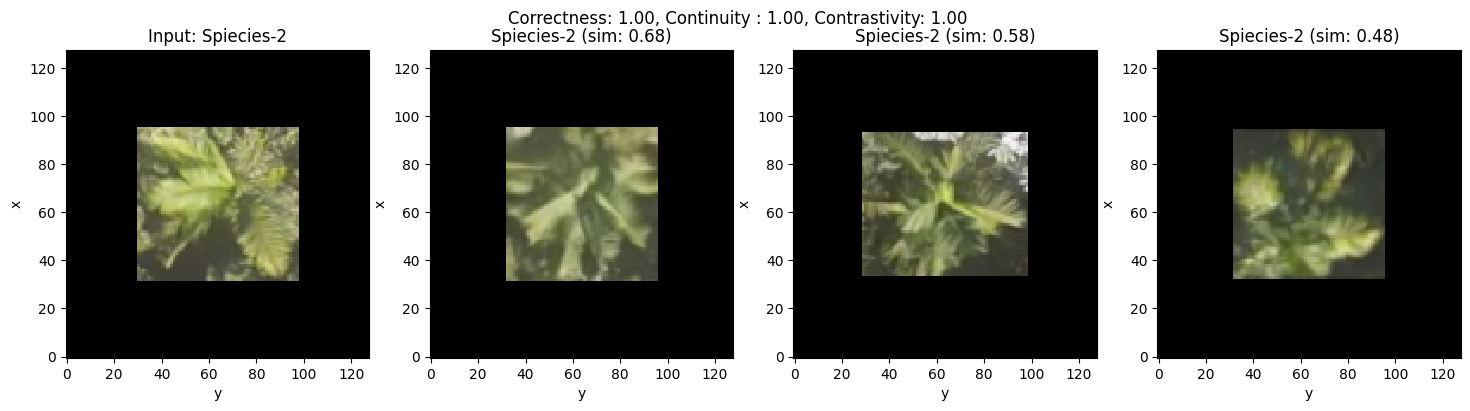

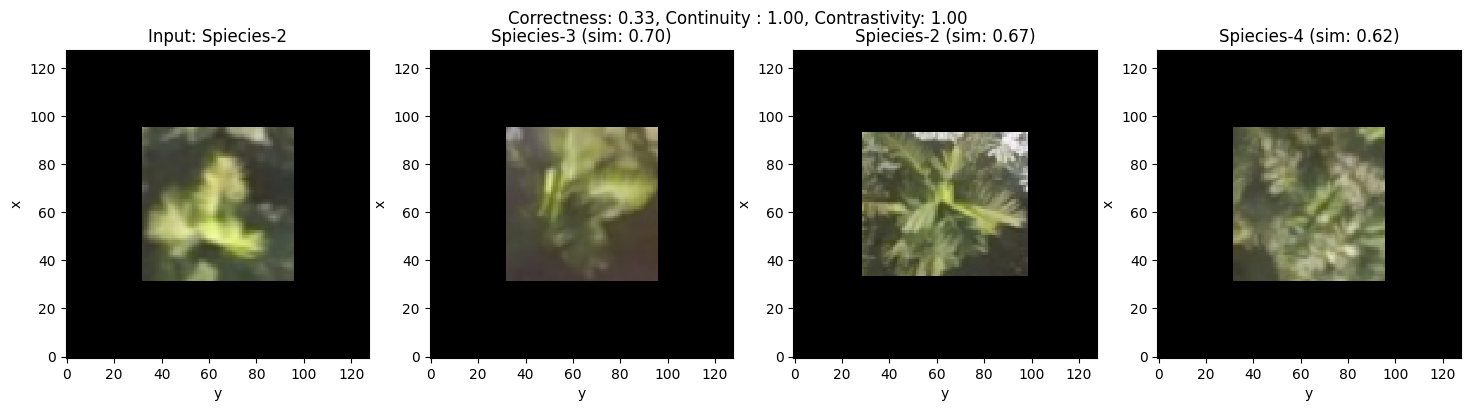

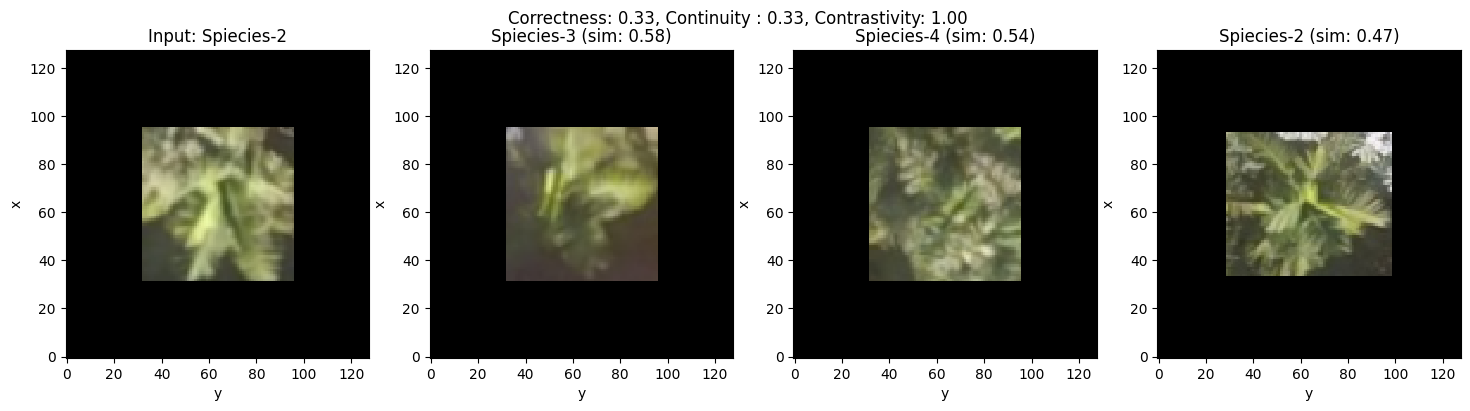

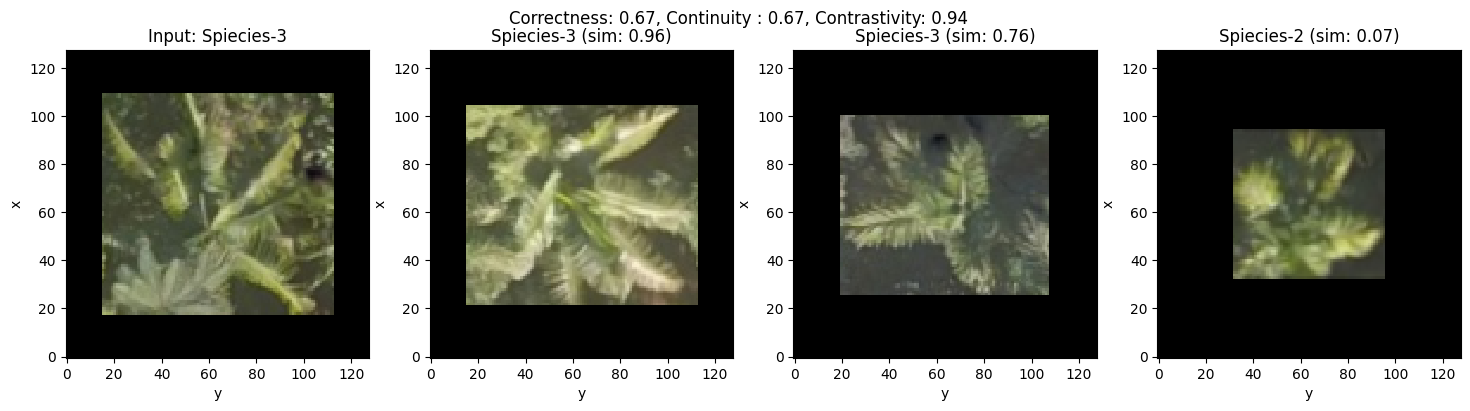

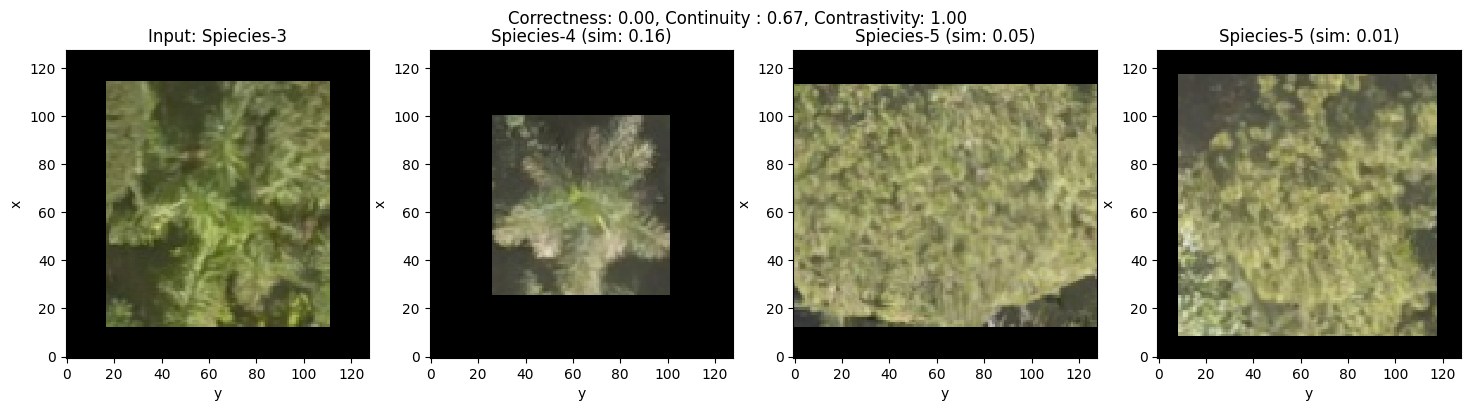

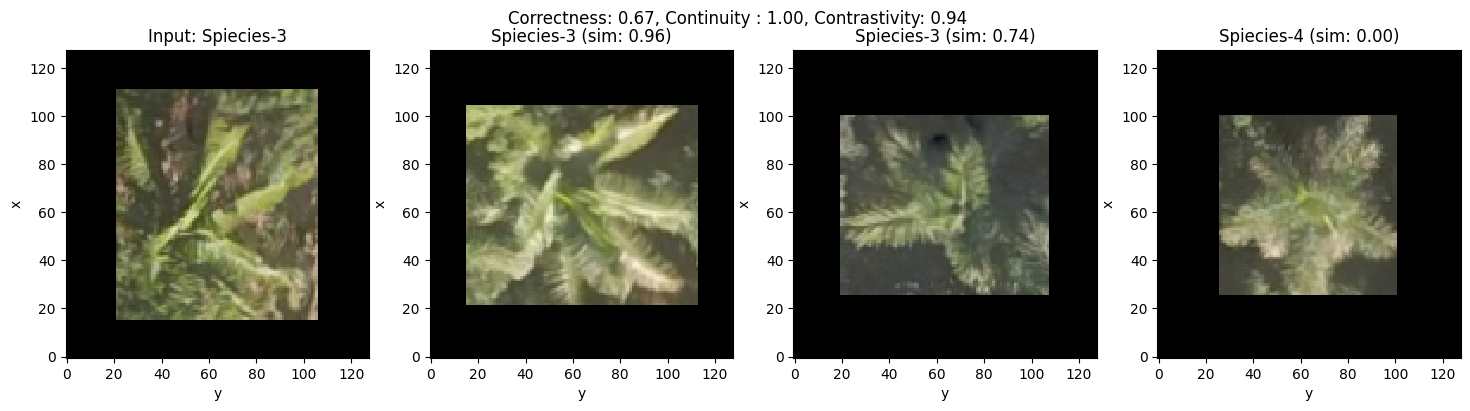

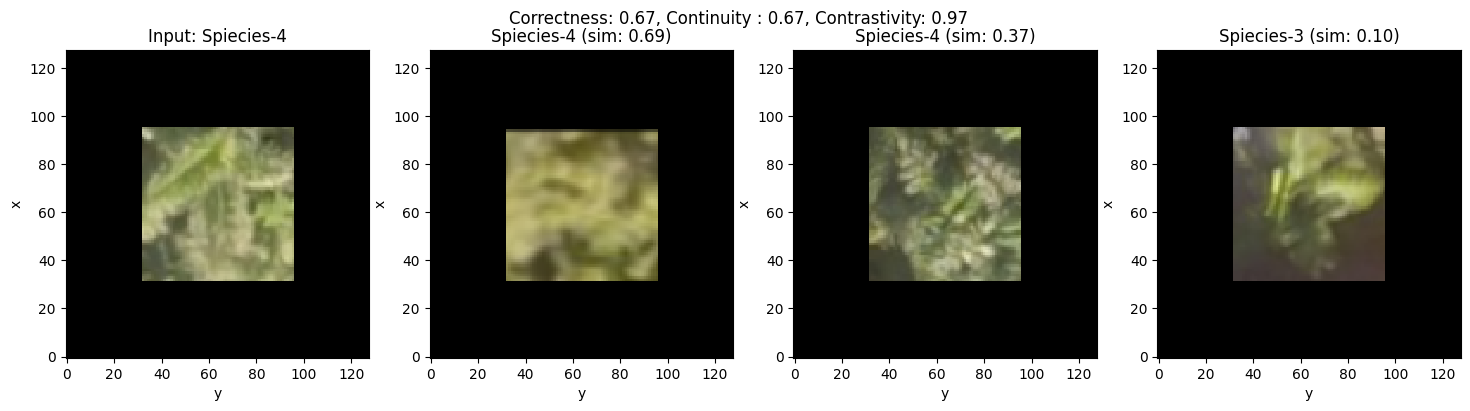

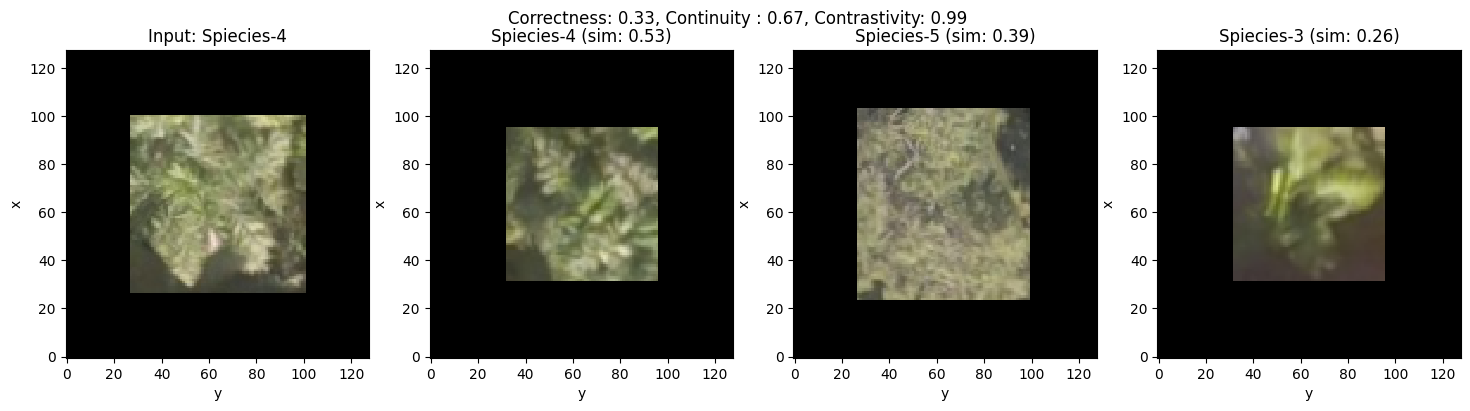

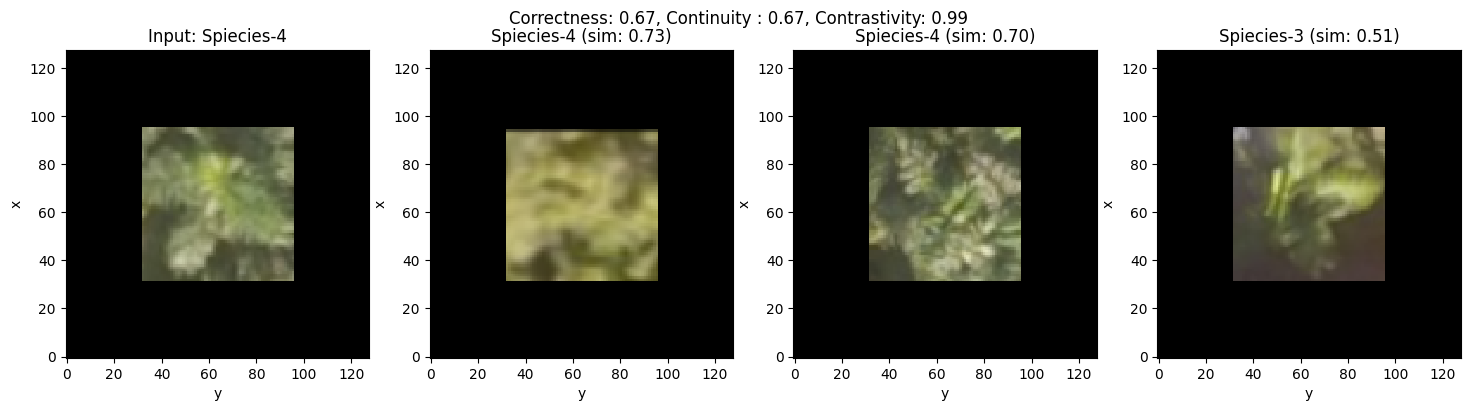

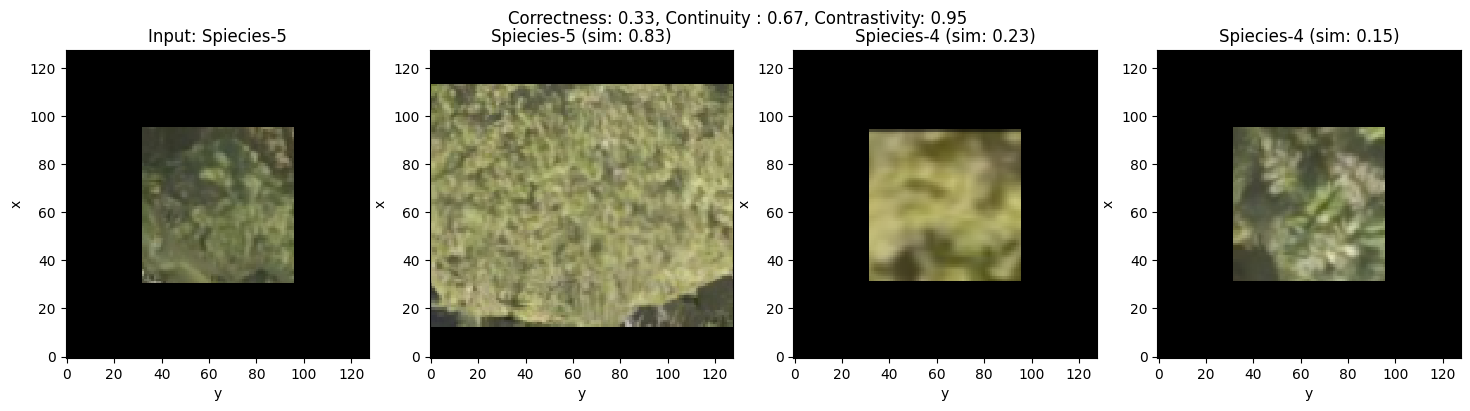

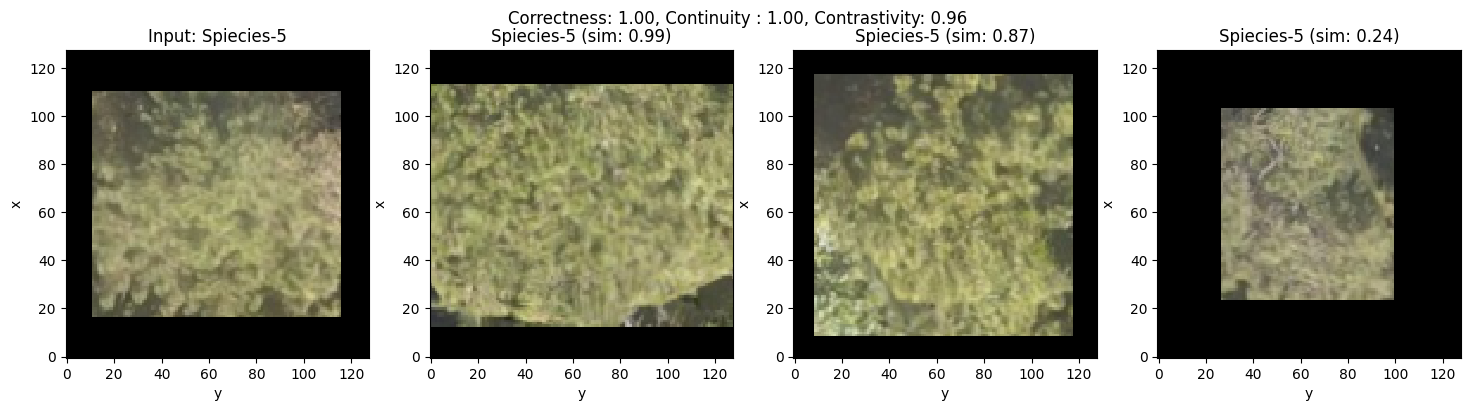

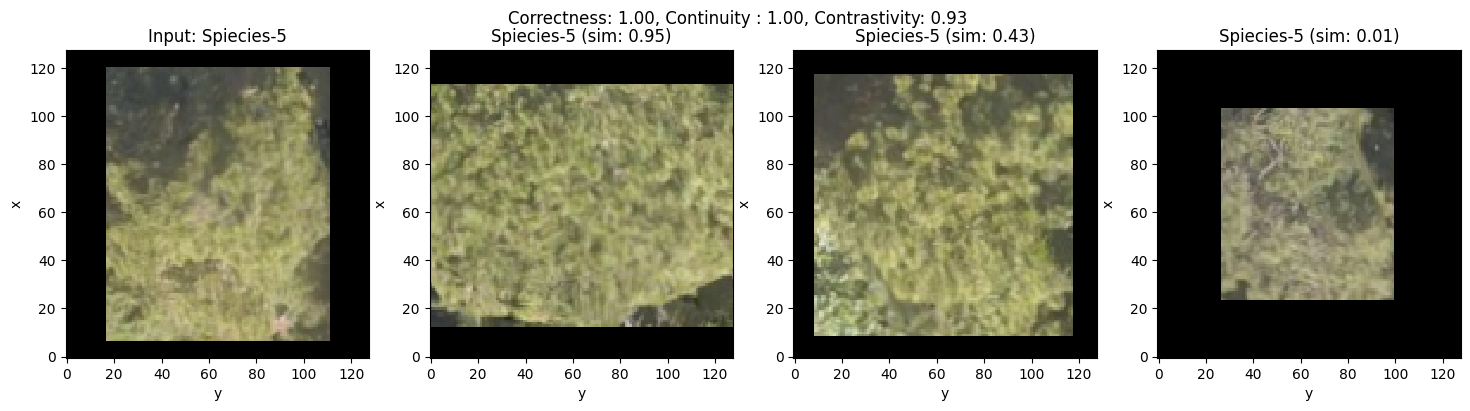

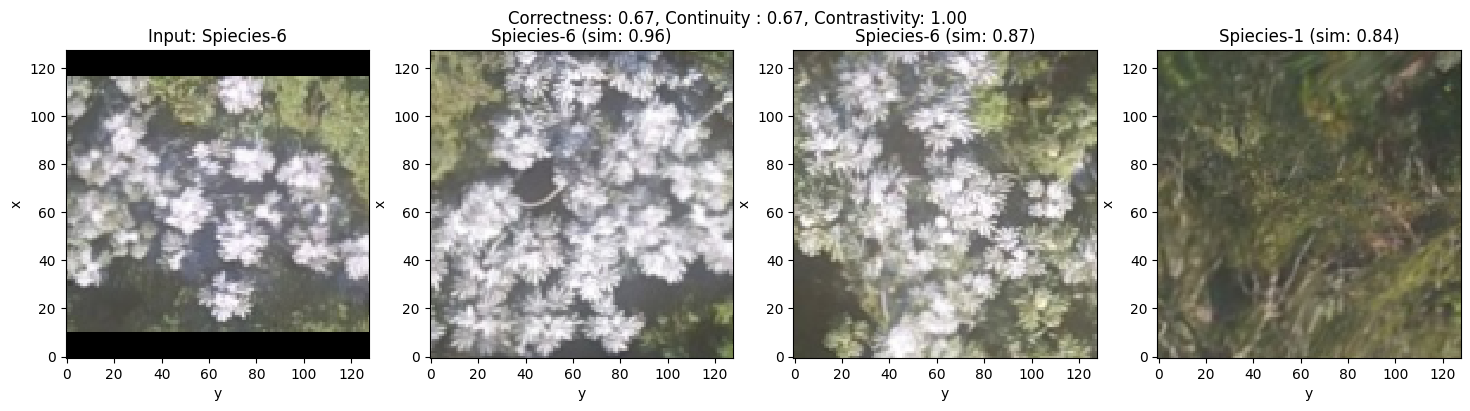

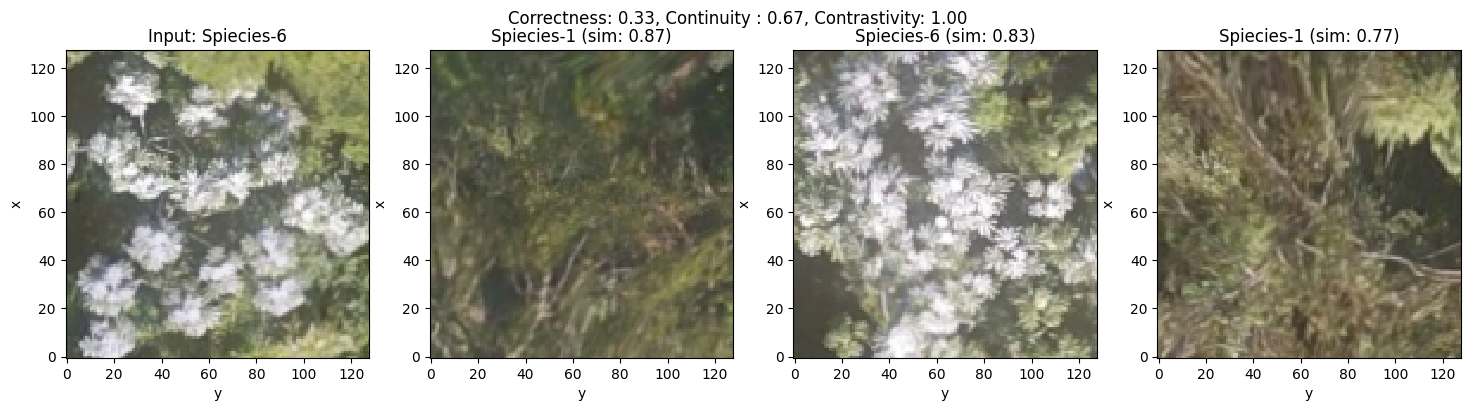

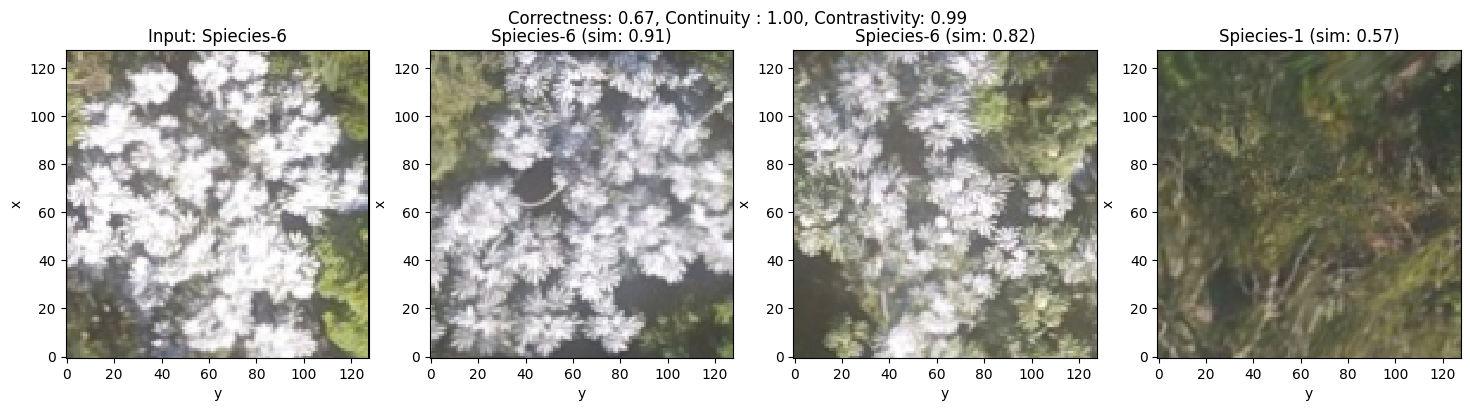

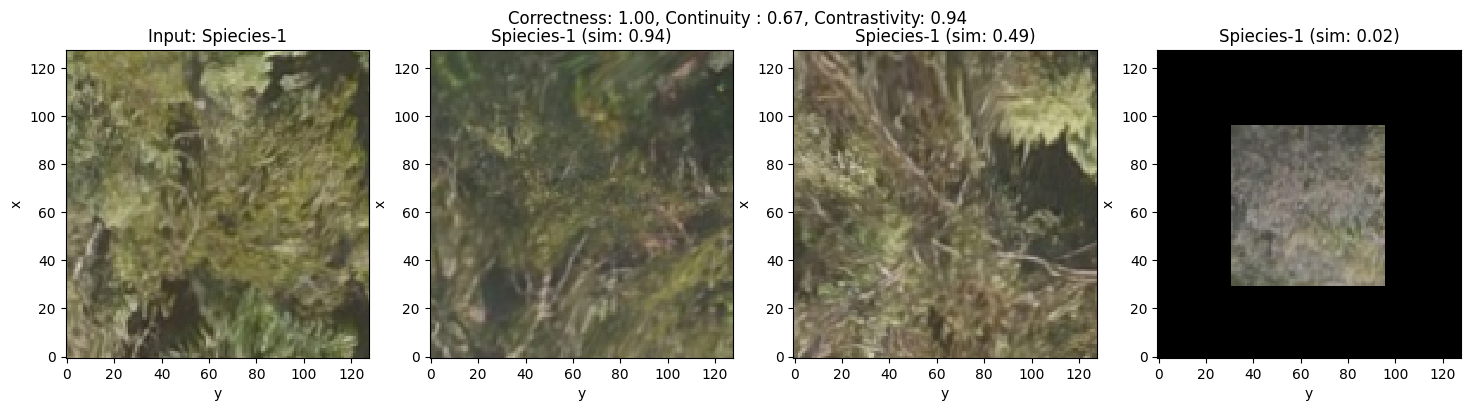

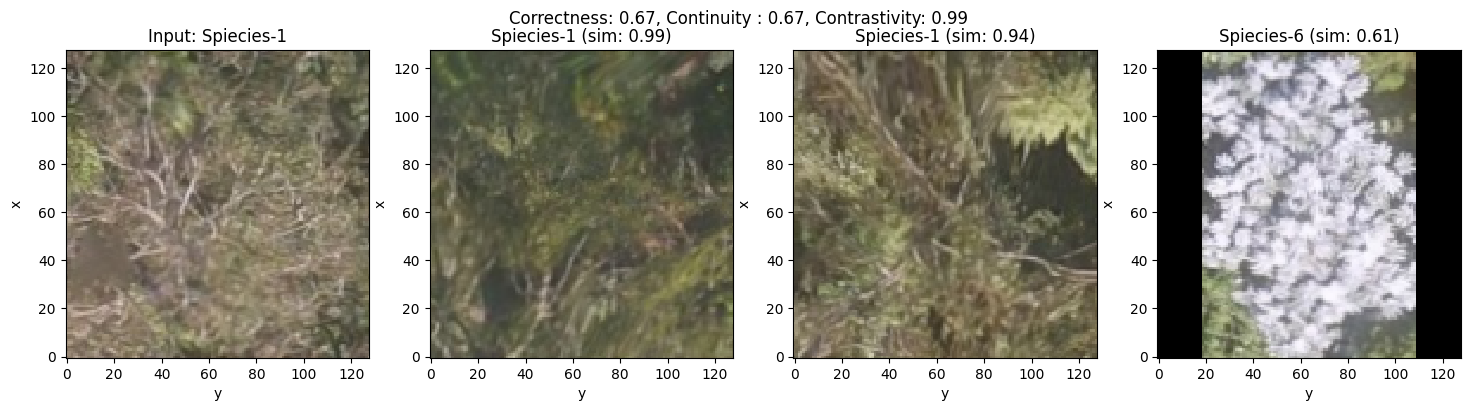

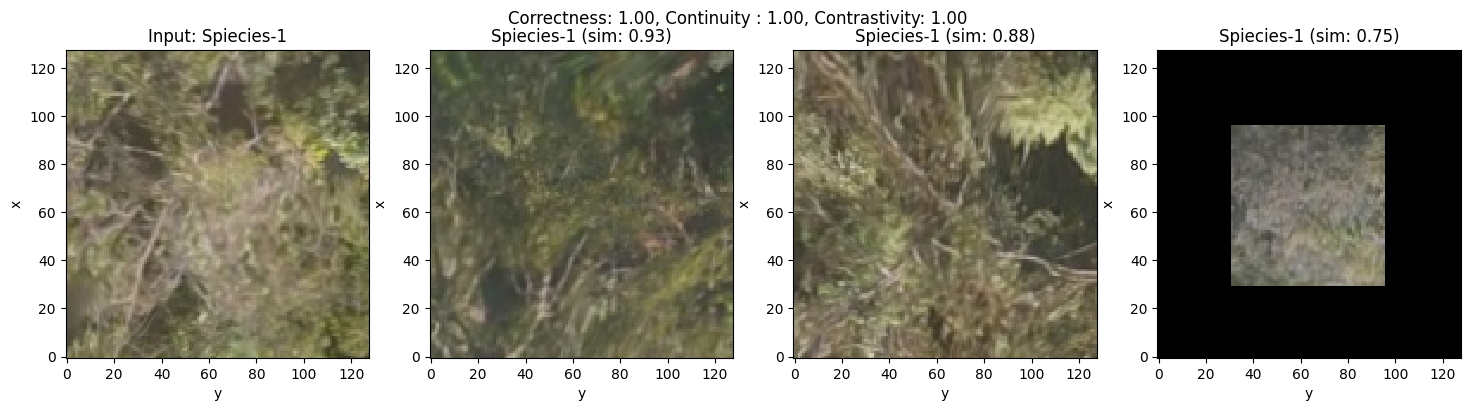

In [9]:
# Compute the results
zero_shot_results = np.zeros((0, 5))
refined_results = np.zeros((0, 5))
print('[ifcorrect, gt_label, similarity_score_of_the_target_class, predicted_class, similarity_score_of_the_predicted_class]')

zero_shot_correctness = []
n_shot_correctness = []

zero_shot_contrastivity  = []
n_shot_contrastivity = []

zero_shot_continuity  = []
n_shot_continuity = []

num_test_smaples = len(test_samples['X']['sample'])
for j in range(num_test_smaples):
    test_sample_j = test_samples.isel(sample=j)
    
    # Make the batch size as the total support_sample size
    support_sample_size =  len(support_samples['X']['sample'])  
    test_Y = test_sample_j['Y'].values 
    test_X = test_sample_j.expand_dims({"sample": support_sample_size})["X"] / 255.0  
    
    # ### Test the base model zero-shot learning
    # # Compute the similarity scores across classes
    zeroshot_score_dic = get_similarity_score(test_X, support_samples, base_model)
    
    # # Compute the prediction results
    zeroshot_result_j = predict_label(test_Y, zeroshot_score_dic, metric="avg")
    print("zero shot", zeroshot_result_j)
        
    
    ### Test the refined model for n-shot learning
    # Compute the similarity scores across classes
    nshot_score_dic = get_similarity_score(test_X, support_samples, refined_model)
    
    # Compute the prediction results
    nshot_result_j = predict_label(test_Y, nshot_score_dic, metric="avg")
    
    # All the results
    print("n-shot", nshot_result_j)
    
    # correctness, contrastivity
    zero_shot_cor, zero_shot_cst= predict_cor_cst(test_Y, zeroshot_score_dic, k)
    zero_shot_correctness.append(zero_shot_cor)
    zero_shot_contrastivity.append(zero_shot_cst)
    
    n_shot_cor, n_shot_cst = predict_cor_cst(test_Y, nshot_score_dic, k)
    n_shot_correctness.append(n_shot_cor)
    n_shot_contrastivity.append(n_shot_cst)
    
    # All the results
    zero_shot_results = np.vstack((zero_shot_results, zeroshot_result_j))
    refined_results = np.vstack((refined_results, nshot_result_j))
    
    # Compute the continuity
    index = np.random.randint(1, 7)
    test_x_agu = aug_img_pair(test_sample_j['X'])[index]
    test_X_agu = test_x_agu.expand_dims({"sample": support_sample_size})/255.0 
      
    # fig1, axs1 = plt.subplots(support_sample_size, 2, figsize=(6, 60))
    # for i in range(support_sample_size):
    #     test_X.isel(sample=i).plot.imshow(ax=axs1[i, 0])
    #     test_X_agu.isel(sample=i).plot.imshow(ax=axs1[i, 1])
        
    zero_shot_cty, zero_ori_similarity_score, zero_agu_similarity_score = predict_cty(test_X, test_X_agu, support_samples, k, base_model)
    zero_shot_continuity.append(zero_shot_cty)
    
    n_shot_cty, n_ori_similarity_score, n_agu_similarity_score  = predict_cty(test_X, test_X_agu, support_samples, k, refined_model)
    n_shot_continuity.append(n_shot_cty)
    
    ### Plot the results
    zero_shor_explanation_scores = [zero_shot_cor, zero_shot_cst, zero_shot_cty]
    n_shor_explanation_scores = [n_shot_cor, n_shot_cst, n_shot_cty]
    
    plot_results(test_sample_j, support_samples, n_ori_similarity_score, n_shor_explanation_scores, k)
    
    
print("-" * 20)   
print("Overall accuracy of the base model", sum(zero_shot_results[:, 0])/num_test_smaples)
print("Overall accuracy of the refined model", sum(refined_results[:, 0])/num_test_smaples) 

print("Correctness of the base model", sum(zero_shot_correctness)/len(zero_shot_correctness))
print("Correctness of the refined model", sum(n_shot_correctness)/len(n_shot_correctness))

print("zero shot contrastivity", zero_shot_contrastivity/max(zero_shot_contrastivity)) 
print("n shot contrastivity", n_shot_contrastivity/max(n_shot_contrastivity)) 

print("zero shot continuity", zero_shot_continuity) 
print("n shot continuity", n_shot_continuity)

gt_zero_shot = zero_shot_results[:, 1]  
pd_zero_shot = zero_shot_results[:, 3]
zero_shot_results = classification_report(gt_zero_shot, pd_zero_shot)
print("***** zero shot results *****")
print(zero_shot_results)

gt_n_shot = refined_results[:, 1]  
pd_n_shot = refined_results[:, 3]
n_shot_results = classification_report(gt_n_shot, pd_n_shot)
cm = confusion_matrix(gt_n_shot, pd_n_shot)
print("***** n shot results *****")
print(n_shot_results)
print(cm)

| k-shot n-Fold | support set | test set     | n-Accuracy  |0-Accuracy  | 
| :---   |    :---              |        :---             | :---   |  :---   |
| 3-1      | (0, 1, 2)                |   (3, 4, 5)                       |  0.89   |  |
| 3-2      | (3, 4, 5)                      | (0, 1, 2)                        | 0.83    | |
| 2-1      | (0, 1)                      | (2, 3, 4, 5)                         | 0.61    |0.22 |
| 2-2      | (2, 3)                      | (0, 1, 4, 5)                         | 0.56    |0.22  |
| 2-3      | (4, 5)                      | (0, 1, 2, 3)                         | 0.56    |0.22  |
| 1-1      | (0)                      | (1, 2, 3, 4, 5)                         | 0.61    |0.31  |
| 1-2      | (1)                      | (0, 1, 2, 3, 4)                         | 0.56    |0.28  |
| 1-3      | (2)                      | (0, 1, 3, 4, 5)                         | 0.50    |0.22  |
| 1-4      | (3)                      | (0, 1, 2, 4, 5)                         | 0.56    |0.11  |
| 1-5      | (4)                      | (0, 1, 2, 3, 5)                         | 0.06    |0.00  |
| 1-6      | (5)                      | (0, 1, 2, 3, 4)                         | 0.61    |0.11  |